# Notebook for experimenting with different blur detection methods

In [4]:
##Load Images
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kwentar/blur-dataset")

print("Path to dataset files:", path)

c:\Users\marom\Desktop\UvA\CV2\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\marom\.cache\kagglehub\datasets\kwentar\blur-dataset\versions\2


## Visualize some of the images, motion blur vs original 

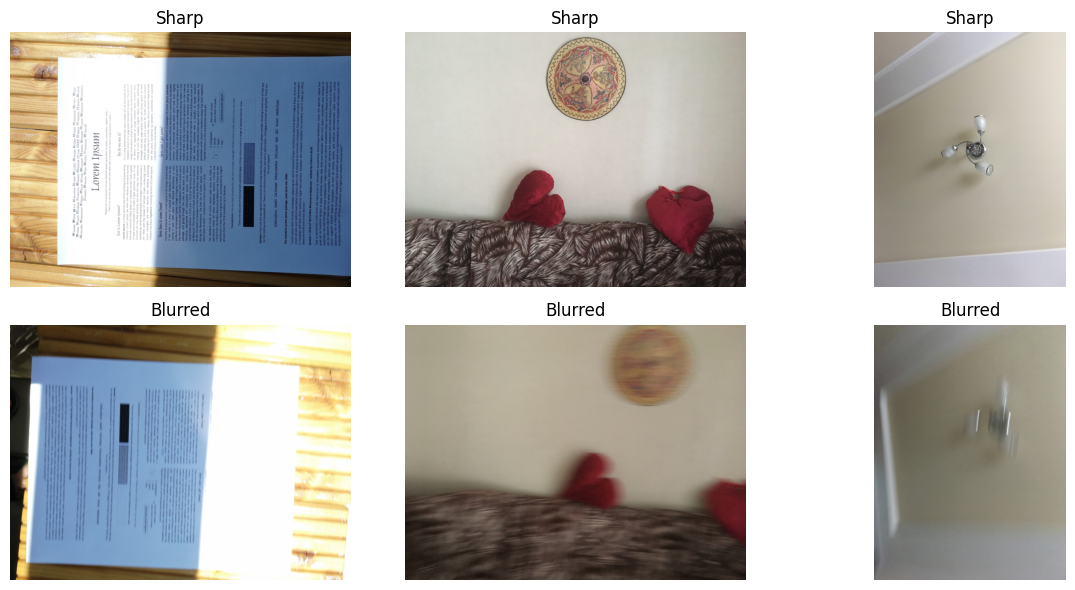

In [5]:
## Visualize some of the images
import os
from PIL import Image
import matplotlib.pyplot as plt

# Define paths
good_frames = os.path.join(path, 'sharp')
bad_frames = os.path.join(path, 'motion_blurred')

good_images = [os.path.join(good_frames, f) for f in os.listdir(good_frames) if f.endswith('.jpg')][:3]
blurred_images = [os.path.join(bad_frames, f) for f in os.listdir(bad_frames) if f.endswith('.jpg')][:3]

# Plot a few images from each category
plt.figure(figsize=(12, 6))

for i in range(3):
    img_good = Image.open(good_images[i])
    img_bad = Image.open(blurred_images[i])

    plt.subplot(2, 3, i + 1)
    plt.imshow(img_good)
    plt.title("Sharp")
    plt.axis('off')

    plt.subplot(2, 3, i + 4)
    plt.imshow(img_bad)
    plt.title("Blurred")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [6]:
#Load all images
good_images = [os.path.join(good_frames, f) for f in os.listdir(good_frames) if f.endswith('.jpg')]
blurred_images = [os.path.join(bad_frames, f) for f in os.listdir(bad_frames) if f.endswith('.jpg')]

### Method 1: Variance of Laplace

Accuracy: 0.76
Precision: 0.78
Recall: 0.74


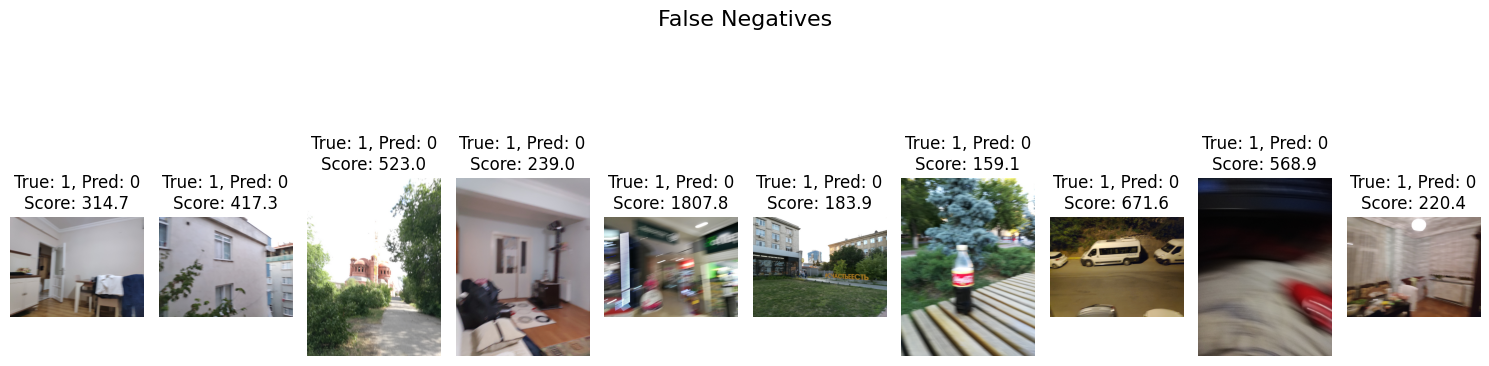

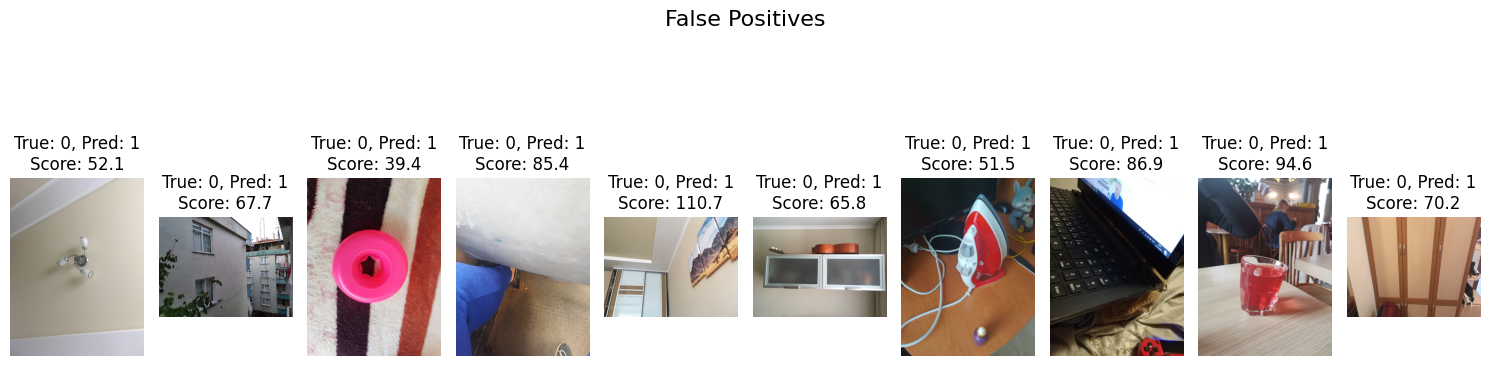

In [22]:
import cv2
import numpy as np
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Function to compute variance of Laplacian (blur detection metric)
def variance_of_laplacian(image):
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    return laplacian.var()

# Parameters
threshold = 120 # I only tried 3 values 80, 100 and 120, 150

# Labels: 0 = sharp, 1 = blurry
true_labels = [0] * len(good_images) + [1] * len(blurred_images)
pred_labels = []

# Store misclassified images: False Negatives and False Positives
false_negatives = []
false_positives = []

# Evaluate images
for img_path, true in zip(good_images + blurred_images, true_labels):
    image = Image.open(img_path)
    score = variance_of_laplacian(image)
    pred = 1 if score < threshold else 0  # 1 = blurry, 0 = sharp
    pred_labels.append(pred)

    if pred != true:
        if pred == 0 and true == 1:  # False Negative
            false_negatives.append((img_path, true, pred, score))
        elif pred == 1 and true == 0:  # False Positive
            false_positives.append((img_path, true, pred, score))

# Metrics
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels)
recall = recall_score(true_labels, pred_labels)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

# Visualize False Negatives and False Positives
def plot_misclassified(misclassified_list, title):
    n = min(10, len(misclassified_list))  # Display up to 10 misclassified images
    if n > 0:
        plt.figure(figsize=(15, 5))
        for i in range(n):
            img_path, true, pred, score = misclassified_list[i]
            img = np.array(Image.open(img_path))
            plt.subplot(1, n, i + 1)
            plt.imshow(img)
            plt.title(f"True: {true}, Pred: {pred}\nScore: {score:.1f}")
            plt.axis('off')
        plt.suptitle(title, fontsize=16)
        plt.tight_layout()
        plt.show()
    else:
        print(f"No {title.lower()} to display.")

# Plot False Negatives and False Positives
plot_misclassified(false_negatives, "False Negatives")
plot_misclassified(false_positives, "False Positives")


### Method 2:  Fast Fourier Transform

In [ ]:
import cv2
import numpy as np
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score


# Function to calculate FFT blur score
def fft_blur_score(image):
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)

    # FFT and shift the zero frequency to the center
    f = np.fft.fft2(gray)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)  # add 1 to avoid log(0)

    # Define a radius for the high frequency region
    center = tuple(map(lambda x: x // 2, magnitude_spectrum.shape))
    radius = 30  # adjust as needed

    # Create a mask to isolate high-frequency components
    Y, X = np.ogrid[:magnitude_spectrum.shape[0], :magnitude_spectrum.shape[1]]
    distance = np.sqrt((X - center[1]) ** 2 + (Y - center[0]) ** 2)
    high_freq_mask = distance > radius

    # Score: average magnitude of high-frequency components
    high_freq_energy = magnitude_spectrum[high_freq_mask].mean()
    # print(high_freq_energy)
    return high_freq_energy

# Threshold for classifying as blurred
threshold = 150  

# Labels
true_labels = [0] * len(good_images) + [1] * len(blurred_images)
pred_labels = []

# Classify and score
for img_path in good_images + blurred_images:
    image = Image.open(img_path)
    score = fft_blur_score(img_path)
    pred = 1 if score < threshold else 0  # 1 = blurry, 0 = sharp
    pred_labels.append(pred)

# Metrics
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels)
recall = recall_score(true_labels, pred_labels)

print(f"FFT Blur Detection => Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}")

FFT Blur Detection => Accuracy: 0.58, Precision: 0.95, Recall: 0.17


### Method 3: Majority voting variance of laplace

Accuracy: 0.72
Precision: 0.69
Recall: 0.78


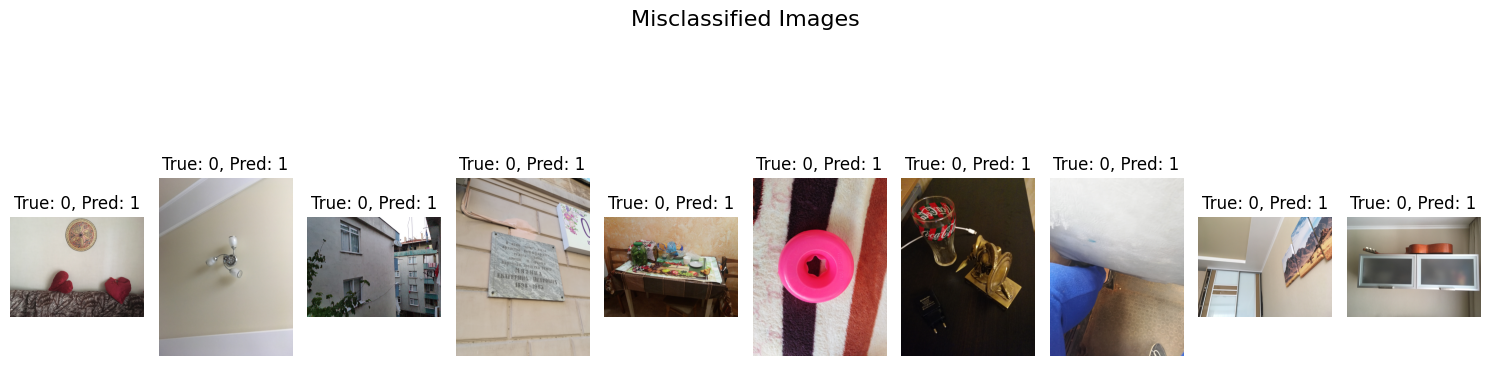

In [19]:
# Function to crop image into 3x3 grid
def crop_image_into_patches(image_path, num_rows=5, num_cols=5):
    image = Image.open(image_path)
    image_np = np.array(image)
    h, w, _ = image_np.shape
    patch_h, patch_w = h // num_rows, w // num_cols
    patches = []

    for i in range(num_rows):
        for j in range(num_cols):
            y1, y2 = i * patch_h, (i + 1) * patch_h
            x1, x2 = j * patch_w, (j + 1) * patch_w
            patch = image_np[y1:y2, x1:x2]
            patches.append(patch)

    return patches

# Parameters
threshold = 120  # 1 = blurry if below threshold, else 0 = sharp

# Labels: 0 = sharp, 1 = blurry
true_labels = [0] * len(good_images) + [1] * len(blurred_images)
pred_labels = []

# Store misclassified images
misclassified_images = []

# Evaluate images using majority voting
for img_path, true in zip(good_images + blurred_images, true_labels):
    patches = crop_image_into_patches(img_path)  # Crop the image into patches
    patch_preds = []

    # Evaluate each patch
    for patch in patches:
        score = variance_of_laplacian(patch)
        pred = 1 if score < threshold else 0  # Blurry if score below threshold
        patch_preds.append(pred)

    # Majority voting to determine final label for the image
    majority_vote = 1 if sum(patch_preds) > len(patch_preds) // 2 else 0
    pred_labels.append(majority_vote)

    # Track misclassified images
    if majority_vote != true:
        misclassified_images.append((img_path, true, majority_vote))

# Metrics
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels)
recall = recall_score(true_labels, pred_labels)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

# Plotting the misclassified images
n = min(10, len(misclassified_images))  # Display up to 10 misclassified images
if n > 0:
    plt.figure(figsize=(15, 5))
    for i in range(n):
        img_path, true, pred = misclassified_images[i]
        img = np.array(Image.open(img_path))
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.title(f"True: {true}, Pred: {pred}")
        plt.axis('off')
    plt.suptitle("Misclassified Images", fontsize=16)
    plt.tight_layout()
    plt.show()
else:
    print("No misclassified images to display.")

### Method 4: Tenengrad (Gradient Magnitude)

Accuracy: 0.82
Precision: 0.94
Recall: 0.69


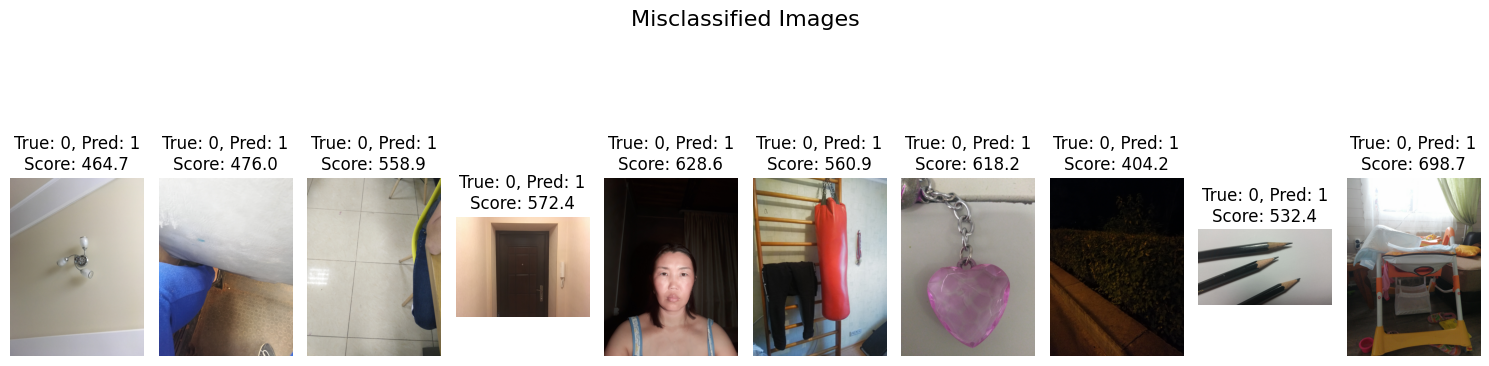

In [16]:
import cv2
import numpy as np
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Function to compute Tenengrad (Sobel gradient magnitude)
def tenengrad(image_path):
    image = Image.open(image_path)
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
    gx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    gy = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    gradient_magnitude = gx**2 + gy**2
    return np.mean(gradient_magnitude)

# Parameters
threshold = 700

# Labels: 0 = sharp, 1 = blurry
all_images = good_images + blurred_images
true_labels = [0] * len(good_images) + [1] * len(blurred_images)
pred_labels = []

misclassified = []

# Evaluate images
for img_path, true in zip(all_images, true_labels):
    score = tenengrad(img_path)
    pred = 1 if score < threshold else 0
    pred_labels.append(pred)
    if pred != true:
        misclassified.append((img_path, true, pred, score))

# Metrics
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels)
recall = recall_score(true_labels, pred_labels)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

# Visualize some misclassified examples
n = min(10, len(misclassified))
if n > 0:
    plt.figure(figsize=(15, 5))
    for i in range(n):
        img_path, true, pred, score = misclassified[i]
        img = np.array(Image.open(img_path))
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.title(f"True: {true}, Pred: {pred}\nScore: {score:.1f}")
        plt.axis('off')
    plt.suptitle("Misclassified Images", fontsize=16)
    plt.tight_layout()
    plt.show()
else:
    print("No misclassified images to display.")

### Method 5: Phase Coherence

ImportError: cannot import name 'phase_congruency' from 'skimage.filters' (c:\Users\marom\Desktop\UvA\CV2\.conda\Lib\site-packages\skimage\filters\__init__.py)